# **Analisis Sentimen Komentar Publik terhadap Timnas Sepakbola Indonesia di Era Shin Tae-Yong Menggunakan Recurrent Neural Network (RNN)**

**Kelompok 66 — Mata Kuliah Deep Learning**  
Universitas Pendidikan Indonesia  
Semester 5 — Tahun 2025  

---

### Anggota:
- Muhamad Khafabillah Sopian (2307824)  
- Abyan Laksono (2304127)  

---


### **Import Library**

Pada tahap ini dilakukan import pustaka (library) yang dibutuhkan untuk melakukan pemrosesan data teks, pembuatan model RNN, serta evaluasi hasilnya.

Fungsi utama setiap library:

pandas → membaca dan mengelola dataset.

numpy → menangani operasi matematis pada array.

re & string → membersihkan teks menggunakan regular expressions.

scikit-learn → menyediakan fungsi train-test split dan metrik evaluasi seperti classification report serta confusion matrix.

tensorflow.keras → membangun dan melatih model RNN.
Termasuk komponen seperti Embedding, SimpleRNN, Dense, dan Dropout.

matplotlib → membantu membuat grafik visualisasi data.

In [ ]:
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### **Load Data**

Dataset yang digunakan berisi komentar publik mengenai Timnas Sepakbola Indonesia di era Shin Tae-Yong, diambil dari media sosial.
Setiap komentar telah diberi label sentimen:

positif — komentar bernada dukungan atau apresiasi

negatif — komentar bernada kritik atau keluhan

Dataset dimuat menggunakan pandas dari file .csv, kemudian disimpan dalam sebuah DataFrame untuk diproses lebih lanjut.

In [ ]:
!pip install gdown -q
import gdown
url = 'https://drive.google.com/uc?id=1ecqfQHVJ4V_V5dy3EgAglrB2gI79xF51'
output = 'Analisis_sentimen_timnas_sepakbola_indonesia_di_era_STY.csv'
gdown.download(url, output, quiet=False)

import pandas as pd
df = pd.read_csv(output)
df.head()


Downloading...
From: https://drive.google.com/uc?id=1ecqfQHVJ4V_V5dy3EgAglrB2gI79xF51
To: /content/Analisis_sentimen_timnas_sepakbola_indonesia_di_era_STY.csv
100%|██████████| 71.6k/71.6k [00:00<00:00, 33.2MB/s]


,komentar,label
0,<username> Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...,negatif
1,<username> <username> <username> keturunan lain yang gak main bola emang bisa di naturalisasi istimewa? kepentingan negara itu sesuatu yg subjektif tergantung petingginya. akal akalan. naturalisasi biasa wajib bisa bahasa indonesia.,negatif
2,"<username> <username> uda botak keturunan penjajah, sok si paling paham tentang bola lu. Coach mentok karir ngelatih futsal aja sok oke lu anjing",negatif
3,"<username> <username> <username> Belum tentu, gak semuanya jadi pemain bola. Dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas. Kalau PSSI cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri.",negatif
4,<username> <username> <username> Lu nya aja yg bego. Makanya nonton sendiri tolol. Persepsi orang beda* nggak harus sama bego. Memang coach tolol sty tolol out aja udah,negatif


## **Exploratory Data Analysis**

Tahap ini bertujuan untuk memahami pola umum dalam dataset.
Beberapa analisis yang dilakukan antara lain:

Distribusi Label
Jumlah data positif dan negatif seimbang, yaitu sekitar 200 komentar untuk masing-masing kelas.
Hal ini penting agar model tidak bias terhadap salah satu kelas.

Panjang Komentar
Sebagian besar komentar berdurasi pendek hingga menengah.
Temuan ini digunakan untuk menentukan parameter panjang maksimum teks (MAX_LEN) saat melakukan padding.

EDA membantu menentukan strategi tokenisasi dan ukuran input yang sesuai untuk model RNN.

In [ ]:
print("Jumlah data:", len(df))
print("\nInfo dataset:")
print(df.info())

# tampilkan 5 baris pertama
df.head()

Jumlah data: 398

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  398 non-null    object
 1   label     398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB
None


,komentar,label
0,<username> Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...,negatif
1,<username> <username> <username> keturunan lain yang gak main bola emang bisa di naturalisasi istimewa? kepentingan negara itu sesuatu yg subjektif tergantung petingginya. akal akalan. naturalisasi biasa wajib bisa bahasa indonesia.,negatif
2,"<username> <username> uda botak keturunan penjajah, sok si paling paham tentang bola lu. Coach mentok karir ngelatih futsal aja sok oke lu anjing",negatif
3,"<username> <username> <username> Belum tentu, gak semuanya jadi pemain bola. Dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas. Kalau PSSI cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri.",negatif
4,<username> <username> <username> Lu nya aja yg bego. Makanya nonton sendiri tolol. Persepsi orang beda* nggak harus sama bego. Memang coach tolol sty tolol out aja udah,negatif


In [ ]:
# Melihat jumlah dan persentase tiap label

print("Distribusi label:")
print(df['label'].value_counts())

print("\nPersentase label (%):")
print(df['label'].value_counts(normalize=True) * 100)

Distribusi label:
label
positif    204
negatif    194
Name: count, dtype: int64

Persentase label (%):
label
positif    51.256281
negatif    48.743719
Name: proportion, dtype: float64


In [ ]:
# Menghitung jumlah kata di setiap komentar

df['length'] = df['komentar'].apply(lambda x: len(str(x).split()))
print("Statistik panjang komentar (dalam jumlah kata):")
print(df['length'].describe())


Statistik panjang komentar (dalam jumlah kata):
count    398.000000
mean      25.708543
std       12.897209
min        0.000000
25%       14.000000
50%       25.000000
75%       37.000000
max       52.000000
Name: length, dtype: float64


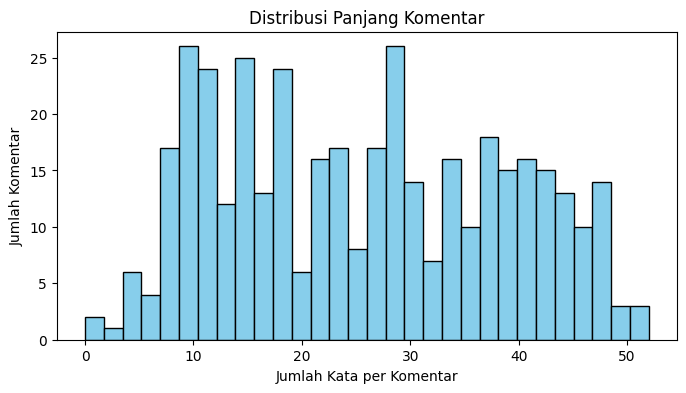

In [ ]:
# Menampilkan distribusi panjang komentar dalam histogram

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Komentar')
plt.xlabel('Jumlah Kata per Komentar')
plt.ylabel('Jumlah Komentar')
plt.show()

In [ ]:
# Menampilkan contoh teks dari tiap kategori sentimen

print("Contoh komentar positif:")
print(df[df['label'] == 'positif']['komentar'].iloc[0])

print("\nContoh komentar negatif:")
print(df[df['label'] == 'negatif']['komentar'].iloc[0])


Contoh komentar positif:
STY tidak pernah mengeluhkan kualitas pemain lokal. Tetapi permasalahan mindset dan etos kerja.. https://t.co/uFigy90uHR

Contoh komentar negatif:
<username> Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...


## **Pre Processing**

Tahap pra-pemrosesan dilakukan untuk membersihkan teks mentah agar model dapat memahami pola bahasa dengan lebih baik.

Langkah-langkah utama:

Menghapus username/mention seperti @garuda atau @PSSI.

Menghapus angka, tanda baca, emoji, dan karakter non-huruf.

Mengubah teks menjadi huruf kecil.

Menghapus spasi ganda dan baris kosong.

Mengubah label teks menjadi angka (positif → 1, negatif → 0).

Hasil pembersihan disimpan dalam kolom baru clean_komentar, yang siap digunakan untuk pemodelan.

In [ ]:
def remove_usernames(text):
    if pd.isna(text):
        return text
    s = str(text)
    s = re.sub(r'(<\s*username\s*>)+', ' ', s, flags=re.IGNORECASE)
    s = re.sub(r'@\w+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['komentar_no_username'] = df['komentar'].apply(remove_usernames)
df[['komentar', 'komentar_no_username']].head()

,komentar,komentar_no_username
0,<username> Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...,Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...
1,<username> <username> <username> keturunan lain yang gak main bola emang bisa di naturalisasi istimewa? kepentingan negara itu sesuatu yg subjektif tergantung petingginya. akal akalan. naturalisasi biasa wajib bisa bahasa indonesia.,keturunan lain yang gak main bola emang bisa di naturalisasi istimewa? kepentingan negara itu sesuatu yg subjektif tergantung petingginya. akal akalan. naturalisasi biasa wajib bisa bahasa indonesia.
2,"<username> <username> uda botak keturunan penjajah, sok si paling paham tentang bola lu. Coach mentok karir ngelatih futsal aja sok oke lu anjing","uda botak keturunan penjajah, sok si paling paham tentang bola lu. Coach mentok karir ngelatih futsal aja sok oke lu anjing"
3,"<username> <username> <username> Belum tentu, gak semuanya jadi pemain bola. Dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas. Kalau PSSI cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri.","Belum tentu, gak semuanya jadi pemain bola. Dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas. Kalau PSSI cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri."
4,<username> <username> <username> Lu nya aja yg bego. Makanya nonton sendiri tolol. Persepsi orang beda* nggak harus sama bego. Memang coach tolol sty tolol out aja udah,Lu nya aja yg bego. Makanya nonton sendiri tolol. Persepsi orang beda* nggak harus sama bego. Memang coach tolol sty tolol out aja udah


In [ ]:
# fungsi untuk bersihkan simbol, angka, dan tanda baca
def clean_symbols_numbers(text):
    if pd.isna(text):
        return text
    s = text.lower()  # ubah ke huruf kecil
    s = re.sub(r'[^a-z\s]', ' ', s)  # hapus karakter non-huruf (angka, tanda baca, emoji)
    s = re.sub(r'\s+', ' ', s).strip()  # rapikan spasi
    return s

# terapkan fungsi ke kolom yang sudah bersih dari username
df['clean_komentar'] = df['komentar_no_username'].apply(clean_symbols_numbers)

# tampilkan hasil sebelum dan sesudah
df[['komentar_no_username', 'clean_komentar']].head(10)

,komentar_no_username,clean_komentar
0,Simulasi indonesia kembali dijajah keturunan belanda kedepan... bye bye talenta anak bangsa lokal indonesia... bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya...,simulasi indonesia kembali dijajah keturunan belanda kedepan bye bye talenta anak bangsa lokal indonesia bubarkan liga dan pencarian bibit unggul atlet bola drpd rusak mental anak bangsanya
1,keturunan lain yang gak main bola emang bisa di naturalisasi istimewa? kepentingan negara itu sesuatu yg subjektif tergantung petingginya. akal akalan. naturalisasi biasa wajib bisa bahasa indonesia.,keturunan lain yang gak main bola emang bisa di naturalisasi istimewa kepentingan negara itu sesuatu yg subjektif tergantung petingginya akal akalan naturalisasi biasa wajib bisa bahasa indonesia
2,"uda botak keturunan penjajah, sok si paling paham tentang bola lu. Coach mentok karir ngelatih futsal aja sok oke lu anjing",uda botak keturunan penjajah sok si paling paham tentang bola lu coach mentok karir ngelatih futsal aja sok oke lu anjing
3,"Belum tentu, gak semuanya jadi pemain bola. Dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas. Kalau PSSI cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri.",belum tentu gak semuanya jadi pemain bola dan yg milih karir sebagai pemain bola pun belum tentu kualitasnya cukup buat timnas kalau pssi cuma fokus ke pemain keturunan mah sama aja mempersempit kolam mereka sendiri
4,Lu nya aja yg bego. Makanya nonton sendiri tolol. Persepsi orang beda* nggak harus sama bego. Memang coach tolol sty tolol out aja udah,lu nya aja yg bego makanya nonton sendiri tolol persepsi orang beda nggak harus sama bego memang coach tolol sty tolol out aja udah
5,"Saya punya saran kepada kita terkenal dengan pola permainan yang cepat jika itu dihilangkan maka itu bahaya besar dalam persepak bolaan kita,. Jadi mohon disampaikan ke . Ini ciri khas permainan kita!!!",saya punya saran kepada kita terkenal dengan pola permainan yang cepat jika itu dihilangkan maka itu bahaya besar dalam persepak bolaan kita jadi mohon disampaikan ke ini ciri khas permainan kita
6,Ini STY ga coba asnawi jadi gelandang aja? VO2 max nya paling tinggi loh diantara pemain timnas.,ini sty ga coba asnawi jadi gelandang aja vo max nya paling tinggi loh diantara pemain timnas
7,"Bukan masalah bnyak kesempatan, tiap taun juga bnyak turnament sebenernya, tpi gua rasa ini salah satu hajat besar pssi, tiap taun cuman bersaing di level asia tenggara. Di piala asia inilah kredibilitas ET/STY di pertaruhkan. Klo pildun mah merem dh jngn ketinggian ekspetasinya.",bukan masalah bnyak kesempatan tiap taun juga bnyak turnament sebenernya tpi gua rasa ini salah satu hajat besar pssi tiap taun cuman bersaing di level asia tenggara di piala asia inilah kredibilitas et sty di pertaruhkan klo pildun mah merem dh jngn ketinggian ekspetasinya
8,"Biasa, sty klo tantrum kan gtu. Semua hal dibawaÂ², mna gaada yg ngingetin pulaa.",biasa sty klo tantrum kan gtu semua hal dibawa mna gaada yg ngingetin pulaa
9,Setelah pulang ke tanah air apakah akan dilempari telur juga layak nya timnas Korsel yg gagal di era sty ðŸ¥²ðŸ¥²ðŸ¥²,setelah pulang ke tanah air apakah akan dilempari telur juga layak nya timnas korsel yg gagal di era sty


In [ ]:
# hapus baris kosong setelah dibersihkan
df = df[df['clean_komentar'].str.strip().astype(bool)].reset_index(drop=True)

# ubah label teks menjadi angka
label2id = {'negatif': 0, 'positif': 1}
df['label_id'] = df['label'].map(label2id)

# cek hasil
df[['clean_komentar', 'label', 'label_id']].tail(20)

,clean_komentar,label,label_id
376,ciee si thom haye lagi ngebut nih karirnya di sepak bola eropa keren banget bro sekarang lagi proses naturalisasi buat main di timnas indonesia semoga bisa jadi pemain tengah kelas dunia deh,positif,1
377,kompetisi dari tahun an hasilnya ya gtu saja hal dasar dalam diet saja masih jauh dari harapan pdhal kalau kata media gaji pemain bola lokal udah tinggi naturalisasi cara yg halal toh yg dicari half blood liga dan pemain di dalam negeri arus bisa cath up nutup gapnya,positif,1
378,masa penduduk an juta masih harus nyari naturalisasi sih buat dpt pemain bola bro jumlah diaspora kita tuh jutaan salah satu yg terbanyak di asia masa dari juta itu trus ada yg jago ga boleh diambil mereka kan aset kita jg,positif,1
379,van burgerking mah udah gamain bola baru dinaturalisasi emang pssi jaman dulu aja kocak naturalisasi asal asalan buktinya lilipaly yang periode sama naturalisasi gagal itu sukses kok,positif,1
380,padahal akar permasalahan ada disitu naturalisasi cuma konsekuensi dari jeleknya kualitas kompetisi dan pembinaan usia dini bola lokal lucunya yang selalu dikritisi konsekuensi nya tapi akar dari permasalahannya pada adem aja,positif,1
381,nah tuh tahu kalau kompetisi sama pembinaan usia muda perlu dibenah naturalisasi keturunan kok terdengar jadi alasan untuk terhambatnya pengembangan sepak bola lokal,positif,1
382,kompetisi bola lokal saja persoalan kinerja wasit tahun ke tahun blm ada perubahan signifikan gue sih setuju naturalisasi pemain berdarah indo,positif,1
383,bang argentina yg juara dunia aja baru ini ambil pemain spanyol loh pemain keturunan udah biasa dalam dunia sepak bola berhubung negara kita ga menganut dwikenegaraan makanya harus naturalisasi,positif,1
384,krn sistem pembinaannya masih blm rapi asal an jd banyak yg takut naturalisasi bikin federasi makin males benerin aspek ini kuncinya ada di keseriusan federasi benahi sistem pembinaan biar g terus dibentur in sm isu naturalisasi,positif,1
385,situasi skrg hampir semua lini kurang kuat untuk bersaing di level asia talenta diaspora blm tentu tiap tahun muncul jd g ada salahnya klo mau memaksimalkan toh buat kepentingan negara jg soal pembinaan ini bahasan berbeda mau ada naturalisasi ngga y harus ttp jln,positif,1


In [ ]:
pd.set_option('display.max_colwidth', None)

# sekarang tampilkan datanya lagi
df[['clean_komentar', 'label', 'label_id']].sample(10, random_state=42)

,clean_komentar,label,label_id
78,gak malah sty masih gambling jelas jelas saat lilipaly maen lawan turkmenistan bagus trus sty juga butuh pemain yg senior tapi malah cuma ada dua aja yg senior yaitu jordi sama klok ini mnurut gua sty kayak kurang pede malah gambling trus ke adam alis yg udh di calling dua kali,negatif,0
277,pelatih timnas shin tae yong masih yakin kalau tim nya mengalami perkembangan yang positif walau menelan hasil mengecewakan dalam uji coba sty masih memiliki dua kesempatan ujicoba untuk menunjukkan performa tim asuhannya sebelum piala asia setuju dengan pendapat sty lob https t co t bayebnfh,positif,1
250,striker lokal ada loh yg dibawa sty sisany yg gk dibawa jauh lebih ampas dari dendy menurut gw,positif,1
55,dendy punya foto bugil sty kayaknya,negatif,0
391,thun llu gk di naturalisasi mgkin msih trauma sama paketan naturalisasi era dualisme dlu lent tkut salah comot taulah sifat org indo klo trauma lebaynya gk ketulungan,positif,1
283,elkan pas debut jg gk bagus adaptasi emang perlu sebelum lolos piala asia pun timnas indo trial error di aff butuh trial error banyak sty ini emang suka eksperimen,positif,1
42,sty out piala asia gagal total phs jadi platih desember juara aff putaran wc,negatif,0
341,mourinho allegri guardiola juga bakal nyerah dengan skuat timnas emang dari fundamentalnya aja gak megang makanya sty bisa bawa tim ini lolos ke asian cup aja udah ajaib,positif,1
152,sty kelas mana,negatif,0
116,emg pelatih nya kek orang gblok pemain oke gbs diolah sty badutt,negatif,0


### **Tokenisasi dan Padding (Text to Numeric Preprocessing)**

Teks tidak bisa langsung diproses oleh model RNN, sehingga perlu diubah menjadi representasi numerik.
Langkah-langkahnya adalah:

Tokenisasi
Setiap kata unik dalam dataset diubah menjadi indeks angka menggunakan Tokenizer.
Contoh: "timnas bagus sekali" → [23, 45, 67].

Padding
Agar setiap input memiliki panjang sama, digunakan fungsi pad_sequences.
Komentar yang lebih pendek akan ditambah dengan nol (0) di akhir urutan.

Tahap ini memastikan model RNN dapat membaca seluruh teks dengan format dimensi yang seragam.

In [ ]:
# Tentukan jumlah kata maksimum dan panjang sequence
MAX_VOCAB = 10000
MAX_LEN = 50

# Membuat kamus kata (tokenizer)
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_komentar'])

# Ubah teks jadi deretan angka
sequences = tokenizer.texts_to_sequences(df['clean_komentar'])

# Terapkan padding supaya semua panjangnya sama
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = np.array(df['label_id'])

# Bagi data jadi train dan validasi
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Jumlah data latih:", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("\nContoh hasil tokenisasi & padding:")
print(X_train[0])


Jumlah data latih: 316
Jumlah data validasi: 80

Contoh hasil tokenisasi & padding:
[   2   18 2243 2244    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## **Modeling: Recurrent Neural Network (RNN) — Klasifikasi Sentimen (Many-to-One)**

Arsitektur model yang digunakan berbasis Recurrent Neural Network (RNN), karena jenis jaringan ini efektif dalam menangkap konteks urutan kata pada teks.

Susunan lapisan model:

Embedding Layer
Mengubah setiap kata menjadi vektor berdimensi 128 untuk merepresentasikan maknanya.

SimpleRNN Layer
Mempelajari hubungan antar kata dalam urutan kalimat.

Dropout Layer
Menonaktifkan sebagian neuron selama pelatihan agar model tidak terlalu menghafal data (overfitting).

Dense Layer (ReLU)
Menghubungkan hasil dari RNN dengan lapisan output.

Dense Layer (Softmax)
Menghasilkan probabilitas dua kelas (positif dan negatif).

Model dikompilasi menggunakan:

Optimizer: Adam

Loss Function: Sparse Categorical Crossentropy

Metrics: Accuracy


In [ ]:
# Model RNN
model_rnn = Sequential([
    Embedding(
        input_dim=min(MAX_VOCAB, len(tokenizer.word_index) + 1),
        output_dim=128
    ),
    SimpleRNN(128),
    Dense(2, activation='softmax')
])

# Kompilasi model
model_rnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## **Pelatihan Model dan Earlystop Training**

Pada tahap ini, model RNN dilatih untuk mengenali pola sentimen dari data komentar.
Untuk mencegah overfitting, digunakan Early Stopping, yaitu mekanisme penghentian otomatis ketika akurasi validasi tidak lagi meningkat.

Parameter yang digunakan:

monitor='val_accuracy': memantau akurasi validasi.

patience=3: menghentikan pelatihan setelah tiga epoch tanpa peningkatan.

restore_best_weights=True: mengembalikan bobot terbaik dari epoch dengan akurasi tertinggi.

Model dilatih menggunakan fit() selama maksimal 15 epoch dengan batch size 64.
Data validasi digunakan untuk memantau kemampuan generalisasi model, sementara callbacks=[es] mengaktifkan Early Stopping.

Selama pelatihan, nilai akurasi dan loss dicatat untuk menilai performa model di setiap epoch.

In [ ]:
# Early stopping untuk menghentikan training jika akurasi validasi tidak meningkat
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Proses training
history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.4831 - loss: 0.7012 - val_accuracy: 0.5500 - val_loss: 0.6964
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7276 - loss: 0.5621 - val_accuracy: 0.5125 - val_loss: 0.7233
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9329 - loss: 0.2683 - val_accuracy: 0.5375 - val_loss: 0.9120
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9918 - loss: 0.0623 - val_accuracy: 0.6000 - val_loss: 0.9291
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.6125 - val_loss: 1.0716
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.5625 - val_loss: 1.2513
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.6125 - val_loss: 1.1711
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.6000 - val_loss: 1.2192

## **Evaluasi Model RNN**

Setelah proses pelatihan selesai, model dievaluasi menggunakan data validasi untuk mengukur kemampuan generalisasi terhadap data baru.

Langkah evaluasi yang dilakukan:

Menghitung akurasi dan loss dengan model.evaluate() sebagai indikator performa keseluruhan.

Menghasilkan prediksi label menggunakan model.predict() untuk seluruh data validasi.

Menampilkan classification report, yang mencakup nilai precision, recall, dan f1-score untuk masing-masing kelas.

Menampilkan confusion matrix untuk melihat jumlah prediksi benar dan salah antara label positif dan negatif.

Hasil evaluasi ini digunakan untuk menilai keseimbangan performa model antara dua kelas serta mendeteksi kemungkinan overfitting.

In [ ]:
# Evaluasi model di data validasi/test
val_loss, val_acc = model_rnn.evaluate(X_val, y_val, verbose=0)
print(f"Akurasi validasi: {val_acc:.4f}")
print(f"Loss validasi: {val_loss:.4f}")

# Prediksi dan laporan klasifikasi
y_pred = model_rnn.predict(X_val, verbose=0).argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['negatif', 'positif']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Akurasi validasi: 0.6125
Loss validasi: 1.0716

Classification Report:
              precision    recall  f1-score   support

     negatif       0.59      0.69      0.64        39
     positif       0.65      0.54      0.59        41

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80


Confusion Matrix:
[[27 12]
 [19 22]]


## **Pembangunan Model RNN dengan Regulasi Dropout**

Pada tahap ini dibangun arsitektur RNN untuk klasifikasi dua kelas dengan regulasi dropout untuk mengurangi overfitting.

Komponen model:

Embedding (128 dimensi): merepresentasikan kata sebagai vektor kontinu.

SimpleRNN (128 unit): memproses urutan kata.

dropout=0.3: menonaktifkan sebagian input secara acak saat pelatihan.

recurrent_dropout=0.3: menonaktifkan sebagian koneksi rekuren.

Dropout(0.4): regulasi tambahan sebelum lapisan keluaran.

Dense(64, ReLU): pemetaan non-linear setelah RNN.

Dense(2, Softmax): menghasilkan probabilitas untuk kelas negatif dan positif.

Model dikompilasi dengan:

Optimizer: Adam

Loss: Sparse Categorical Crossentropy

Metrik: Accuracy

Tujuan konfigurasi ini adalah menjaga keseimbangan antara kapasitas model dan kemampuan generalisasi pada dataset berukuran kecil.

In [ ]:
# Bangun model RNN dengan Dropout (versi regulasi dropout sedang)
model_rnn = Sequential([
    Embedding(
        input_dim=min(MAX_VOCAB, len(tokenizer.word_index) + 1),
        output_dim=128
    ),
    SimpleRNN(
        128,
        return_sequences=False,
        dropout=0.3,             # matikan 30% neuron input
        recurrent_dropout=0.3    # matikan 30% koneksi antar waktu
    ),
    Dropout(0.4),                # dropout tambahan setelah RNN
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model_rnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## **Proses Pelatihan Model RNN Dropout**

Setelah model RNN dengan regulasi dropout selesai dibangun, dilakukan proses pelatihan menggunakan data latih dan validasi.
Tujuan tahap ini adalah menyesuaikan bobot model agar mampu mengenali pola sentimen dengan baik.

Parameter pelatihan:

epochs=15 — jumlah maksimum iterasi pelatihan.

batch_size=64 — jumlah data yang diproses setiap langkah pembaruan bobot.

validation_data — digunakan untuk mengevaluasi performa model di luar data pelatihan.

callbacks=[es] — menerapkan mekanisme early stopping untuk menghentikan pelatihan jika akurasi validasi tidak meningkat dalam tiga epoch berturut-turut.

Selama proses ini, model mempelajari representasi fitur dari komentar dan menyesuaikan bobot internal untuk meminimalkan nilai loss serta meningkatkan akurasi validasi.

In [ ]:
history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.4847 - loss: 0.7765 - val_accuracy: 0.4375 - val_loss: 0.7003
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5083 - loss: 0.7438 - val_accuracy: 0.4375 - val_loss: 0.7008
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5131 - loss: 0.7444 - val_accuracy: 0.4250 - val_loss: 0.6992
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5149 - loss: 0.7295 - val_accuracy: 0.4750 - val_loss: 0.6958
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4983 - loss: 0.7275 - val_accuracy: 0.5250 - val_loss: 0.6881
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5415 - loss: 0.6927 - val_accuracy: 0.5375 - val_loss: 0.6872
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5331 - loss: 0.6943 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4826 - loss: 0.7462 - val_accuracy: 0.5250 - val_loss: 0.6888

## **Evaluasi Akhir Model RNN dengan Dropout**

Pada tahap ini dilakukan penilaian performa model yang telah dilatih dengan regulasi dropout menggunakan data validasi.

Langkah evaluasi:

model.evaluate() menghitung metrik agregat: akurasi dan loss pada data validasi.

model.predict() menghasilkan prediksi probabilitas; kemudian diambil argmax sebagai label akhir.

classification_report menampilkan precision, recall, dan F1-score per kelas (negatif, positif) serta rata-ratanya (macro dan weighted).

confusion_matrix menunjukkan jumlah prediksi benar/salah per kelas:

Baris = label sebenarnya.

Kolom = label prediksi.

Gunakan hasil ini untuk:

Memeriksa keseimbangan performa antar kelas (apakah salah satu kelas jauh lebih rendah).

Mengamati trade-off precision–recall pada tiap kelas.

Mengidentifikasi pola kesalahan pada confusion matrix (misalnya kelas yang sering tertukar).

In [ ]:
# Evaluasi Akhir Model RNN Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Evaluasi di data validasi
val_loss, val_acc = model_rnn.evaluate(X_val, y_val, verbose=0)
print(f"Akurasi validasi: {val_acc:.4f}")
print(f"Loss validasi: {val_loss:.4f}")

# Prediksi label di data validasi
y_pred = np.argmax(model_rnn.predict(X_val), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['negatif', 'positif']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Akurasi validasi: 0.5500
Loss validasi: 0.6876
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step

Classification Report:
              precision    recall  f1-score   support

     negatif       0.54      0.56      0.55        39
     positif       0.56      0.54      0.55        41

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.55        80
weighted avg       0.55      0.55      0.55        80


Confusion Matrix:
[[22 17]
 [19 22]]


## **Kesimpulan**

Eksperimen ini bertujuan untuk menerapkan model Recurrent Neural Network (RNN) pada tugas sentiment analysis berbahasa Indonesia menggunakan dataset opini masyarakat terhadap Timnas Indonesia di era Shin Tae-yong. Proses penelitian meliputi tahap eksplorasi data (EDA), praproses teks, tokenisasi dan padding, pembangunan model RNN, pelatihan, serta evaluasi performa.

Model yang digunakan terdiri dari Embedding layer (128 dimensi), SimpleRNN (128 unit), dan Dense layer output dengan aktivasi softmax. Data dibagi menjadi 80% data latih (316 data) dan 20% data validasi (80 data). Proses pelatihan dilakukan selama maksimal 15 epoch menggunakan Early Stopping untuk mencegah overfitting.

Hasil evaluasi menunjukkan bahwa model RNN mencapai:

Akurasi validasi: sekitar 0.55 (55%)

Loss validasi: sekitar 0.69

Rata-rata Precision, Recall, dan F1-score: ± 0.55

Berdasarkan Confusion Matrix, model sering mengklasifikasikan teks ke kelas negatif, menandakan adanya kecenderungan bias negatif.

Analisis menunjukkan bahwa keterbatasan ukuran dataset (398 data), jumlah kata positif yang relatif sedikit, serta kemampuan RNN yang kurang optimal dalam memahami konteks kalimat panjang menjadi faktor utama rendahnya akurasi. Penambahan Dropout (30–40%) berhasil mengurangi overfitting namun belum memberikan peningkatan signifikan terhadap performa model.

Secara keseluruhan, model RNN ini berhasil mengenali pola dasar sentimen namun masih belum stabil dalam membedakan kalimat positif dan negatif secara kontekstual. Hasil ini menjadi baseline awal yang akan dibandingkan dengan model LSTM (Long Short-Term Memory) pada eksperimen berikutnya, yang diharapkan mampu memahami konteks urutan kata dengan lebih baik dan menghasilkan akurasi yang lebih tinggi.